### How does noise affect Gaussian best-fits to spectral data?

Here we'll create synthetic spectra with a fake "emission line" with a known FWHM plus random noise, then fit a Gaussian lineshape to them and see how the best-fit FWHM compares to the true FWHM.

In [25]:
from matplotlib import pyplot as plt
from astropy.modeling import models
from astropy import units as u
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines

import numpy as np


### Relationship between Gaussian lineshape, $\sigma$, and FWHM

See [Wikipedia](https://en.wikipedia.org/wiki/Full_width_at_half_maximum).  A normal distribution with standard deviation $\sigma$ 
is given by the equation

$$
f(x) = \exp{\left[ -\frac{(x-x_0)^2}{2 \sigma^2}\right]}
$$
The FWHM = $2\sqrt{2 \ln 2}\sigma \approx 2.355 \sigma$.

A function to create a synthetic Gaussian bump spectrum

In [26]:
def synthetic_spectrum(dlambda,lambdda0,lambda_fwhm,signal_level,snr):
    # dlambda = spectral distance between adjacent pixels, nm
    # lambda0 = central wavelength of spectral peak
    # lambda_fwhm = FWHM of spectral peak
    # signal_level = height of peak
    # snr = signal-to-noise ratio
    
    lambda_sigma = lambda_fwhm/(2*np.sqrt(2*np.log(2)))
    noise_level = signal_level/snr
    wavel  = np.arange(lambdda0-10*lambda_fwhm,lambdda0+10*lambda_fwhm,dlambda)
    power = signal_level*np.exp(-(wavel-lambdda0)**2/(2*lambda_sigma**2)) + noise_level*np.random.randn(len(wavel))
    return wavel,power

Create a single synthetic spectrum and plot it}

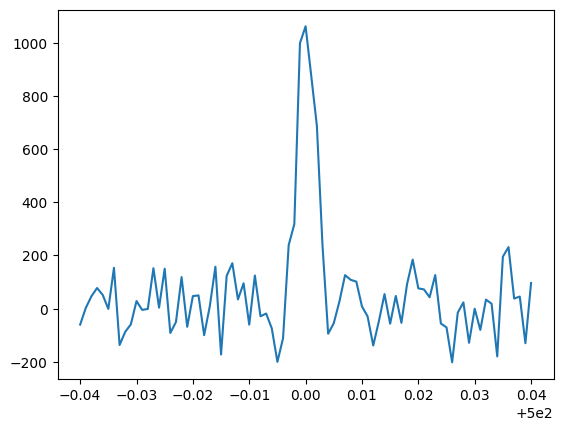

In [27]:
wavel,power = synthetic_spectrum(dlambda=.001,lambdda0=500,lambda_fwhm=.004,signal_level=1000,snr=10)
plt.plot(wavel,power)

Use the specutils fit_lines function to generate a Gaussian best-fit, and plot it.  Print out the "true" FWHM and the best-fit FWHM for comparison.

original fwhm = 0.004, fit fwhm = 0.003707989344765617


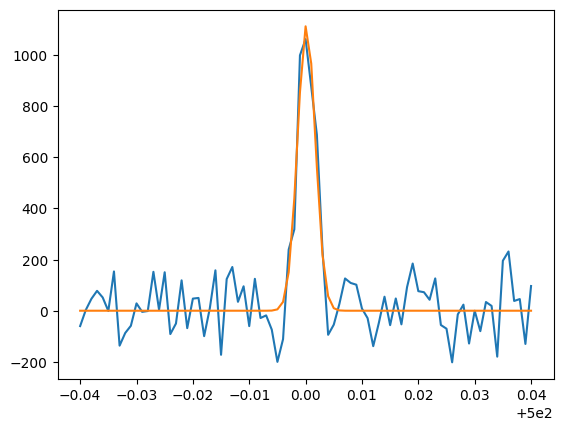

In [28]:
spectrum = Spectrum1D(flux=power*u.dimensionless_unscaled, spectral_axis=wavel*u.nm)
g_init = models.Gaussian1D(amplitude=1000*u.dimensionless_unscaled, mean=500*u.nm, stddev=.004*u.nm)
g_fit = fit_lines(spectrum, g_init, window=(wavel[0]*u.nm, wavel[-1]*u.nm))
standard_deviation= g_fit.stddev.value
fwhm = standard_deviation * 2*np.sqrt(2*np.log(2))
y_fit = g_fit(wavel*u.nm)
plt.plot(spectrum.spectral_axis, spectrum.flux,wavel,y_fit) 
print(f'original fwhm = {.004}, fit fwhm = {fwhm}')

Explore the statistics of the best-fit FWHM by calculating best-fit FWHMs for 1000 spectra and creating a histogram.

Text(0.5, 1.0, 'Histogram of FWHM fits with SNR=10,true FWHM=0.004, resolution=0.001')

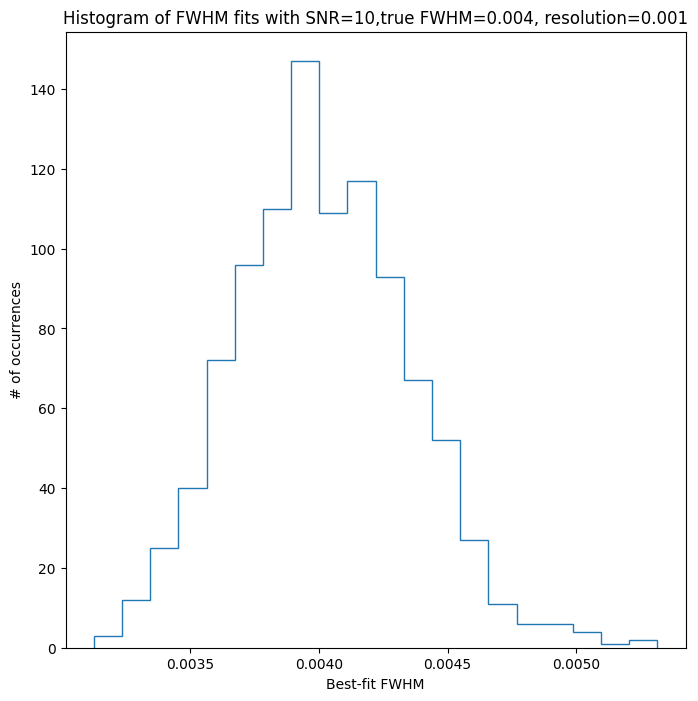

In [29]:
fit_fwhms = np.zeros(1000)
for i in range(1000):
    wavel,power = synthetic_spectrum(dlambda=.001,lambdda0=500,lambda_fwhm=.004,signal_level=1000,snr=10)
    spectrum = Spectrum1D(flux=power*u.dimensionless_unscaled, spectral_axis=wavel*u.nm)
    g_init = models.Gaussian1D(amplitude=1000*u.dimensionless_unscaled, mean=500*u.nm, stddev=.004*u.nm)
    g_fit = fit_lines(spectrum, g_init, window=(wavel[0]*u.nm, wavel[-1]*u.nm))
    fit_fwhms[i] = g_fit.stddev.value * 2*np.sqrt(2*np.log(2))

counts, bins = np.histogram(fit_fwhms,20)
plt.figure(figsize=(8,8))
plt.stairs(counts, bins)
plt.xlabel('Best-fit FWHM')
plt.ylabel('# of occurrences')
plt.title(f'Histogram of FWHM fits with SNR={10},true FWHM={.004}, resolution={.001}')